# Mammography Report Classification with DistilBERT PT

**Competition:** SPR 2026 Mammography Report Classification  
**Task:** Predict BI-RADS category (0–6) from Portuguese mammography reports  
**Model:** `adalbertojunior/distilbert-portuguese-cased` (DistilBERT trained on Portuguese)

## BI-RADS Categories
| Class | Meaning |
|-------|---------|
| 0 | Incomplete — needs additional imaging |
| 1 | Negative — no abnormality |
| 2 | Benign — definitely benign finding |
| 3 | Probably benign — short-interval follow-up |
| 4 | Suspicious — tissue sampling advised |
| 5 | Highly suggestive of malignancy |
| 6 | Known biopsy-proven malignancy |

## 1. Setup & Imports

In [1]:
# Install dependencies if needed
# !pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
)

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


def resolve_device():
    """Select CUDA only if a tiny forward/backward pass succeeds."""
    if not torch.cuda.is_available():
        return torch.device("cpu")

    try:
        # Smoke-test CUDA to catch runtime incompatibilities early
        x = torch.randn(4, 4, device="cuda")
        w = torch.randn(4, 4, device="cuda", requires_grad=True)
        y = (x @ w).sum()
        y.backward()
        _ = torch.cuda.get_device_name(0)
        return torch.device("cuda")
    except Exception as e:
        print("CUDA available but unusable in this runtime. Falling back to CPU.")
        print(f"Reason: {type(e).__name__}: {e}")
        print("Tip: install a PyTorch build compatible with your GPU (e.g., cu118 for GTX 10xx).")
        return torch.device("cpu")


DEVICE = resolve_device()
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")



/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce GTX 1060 6GB


## 2. Config

In [3]:
# ── Paths ─────────────────────────────────────────────────────────────────────
DATA_DIR   = "../data"
OUTPUT_DIR = "./outputs_distilbert"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Model ─────────────────────────────────────────────────────────────────────
# DistilBERT PT: compact Portuguese encoder model
MODEL_NAME  = "adalbertojunior/distilbert-portuguese-cased"
NUM_CLASSES = 7   # BI-RADS 0–6
MAX_LEN     = 512 # Max BERT tokens (reports avg ~120 tokens, max ~400)

# ── Split ─────────────────────────────────────────────────────────────────────
TEST_SIZE = 0.20  # 20% held-out test set

# ── Training ──────────────────────────────────────────────────────────────────
N_FOLDS      = 5
EPOCHS       = 4
BATCH_SIZE   = 16
ACCUM_STEPS  = 2   # Effective batch = 32
LR           = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
USE_CLASS_WEIGHTS = False



## 3. Data Split

Split `data.csv` into `train.csv` (80%) and `test.csv` (20%) using a **stratified** split
so that every BI-RADS class is proportionally represented in both sets.

The split files are saved to `../data/` and reused in later runs (no re-splitting).

In [4]:
data_df = pd.read_csv(f"{DATA_DIR}/data.csv")
print(f"Full dataset: {data_df.shape}")

train_df, test_df = train_test_split(
    data_df,
    test_size=TEST_SIZE,
    stratify=data_df["target"],
    random_state=SEED,
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df.to_csv(f"{DATA_DIR}/train.csv", index=False)
test_df.to_csv(f"{DATA_DIR}/test.csv",  index=False)

print(f"Train: {train_df.shape}")
print(f"Test:  {test_df.shape}")

# ── Verify class proportions are preserved ────────────────────────────────────
split_summary = pd.DataFrame({
    "Full":  data_df["target"].value_counts().sort_index(),
    "Train": train_df["target"].value_counts().sort_index(),
    "Test":  test_df["target"].value_counts().sort_index(),
})
split_summary["Train %"] = (split_summary["Train"] / split_summary["Full"] * 100).round(1)
split_summary["Test %"]  = (split_summary["Test"]  / split_summary["Full"] * 100).round(1)
print("\nClass distribution after split:")
print(split_summary)

Full dataset: (18272, 3)
Train: (14617, 3)
Test:  (3655, 3)

Class distribution after split:
         Full  Train  Test  Train %  Test %
target                                     
0         610    488   122     80.0    20.0
1         693    555   138     80.1    19.9
2       15968  12774  3194     80.0    20.0
3         713    570   143     79.9    20.1
4         214    171    43     79.9    20.1
5          29     23     6     79.3    20.7
6          45     36     9     80.0    20.0


## 4. Exploratory Data Analysis

In [5]:
train_df.head(3)

,ID,report,target
0,Acc19258,Indicação clínica:\n\r rastreamento.\n\rAchado...,2
1,Acc6749,Indicação clínica:\n\r rastreamento.\n\rAchado...,2
2,Acc19497,Indicação clínica:\n\r rastreamento.\n\rAchado...,2


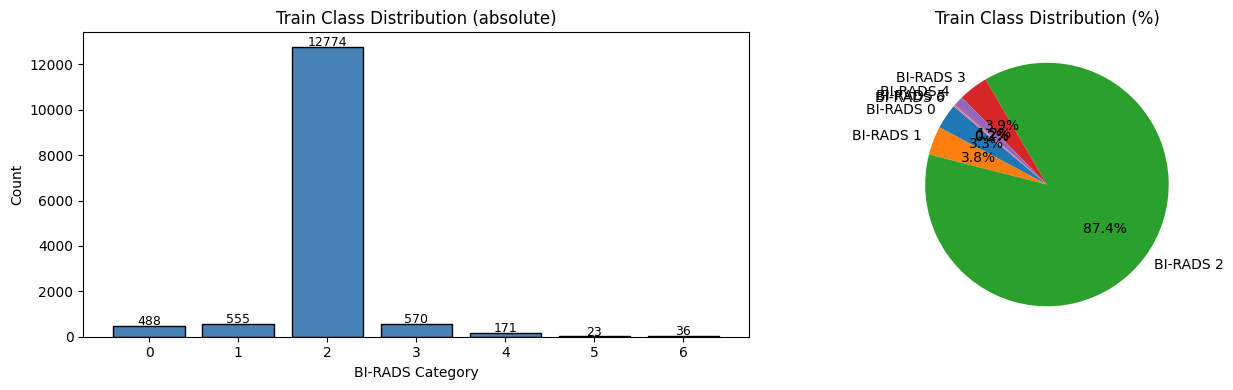


Train class counts:
target
0      488
1      555
2    12774
3      570
4      171
5       23
6       36
Name: count, dtype: int64


In [6]:
# ── Class distribution ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

counts = train_df["target"].value_counts().sort_index()
axes[0].bar(counts.index.astype(str), counts.values, color="steelblue", edgecolor="black")
axes[0].set_xlabel("BI-RADS Category")
axes[0].set_ylabel("Count")
axes[0].set_title("Train Class Distribution (absolute)")
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 30, str(v), ha="center", fontsize=9)

axes[1].pie(counts.values, labels=[f"BI-RADS {c}" for c in counts.index],
            autopct="%1.1f%%", startangle=140)
axes[1].set_title("Train Class Distribution (%)")

plt.tight_layout()
plt.show()

print("\nTrain class counts:")
print(counts)

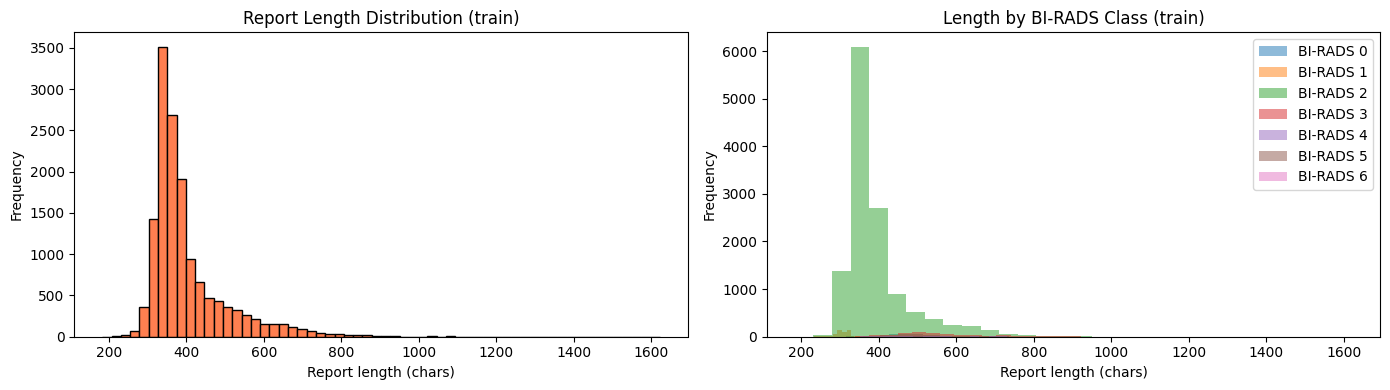

count    14617.000000
mean       400.619074
std        103.531591
min        183.000000
25%        332.000000
50%        363.000000
75%        423.000000
max       1622.000000
Name: char_len, dtype: float64


In [7]:
# ── Report length analysis ────────────────────────────────────────────────────
train_df["char_len"] = train_df["report"].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(train_df["char_len"], bins=60, color="coral", edgecolor="black")
axes[0].set_xlabel("Report length (chars)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Report Length Distribution (train)")

for cls in sorted(train_df["target"].unique()):
    subset = train_df[train_df["target"] == cls]["char_len"]
    axes[1].hist(subset, bins=30, alpha=0.5, label=f"BI-RADS {cls}")
axes[1].set_xlabel("Report length (chars)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Length by BI-RADS Class (train)")
axes[1].legend()

plt.tight_layout()
plt.show()

print(train_df["char_len"].describe())

In [8]:
# ── Duplicate reports ──────────────────────────────────────────────────────────
n_dup = train_df["report"].duplicated().sum()
print(f"Duplicate reports in train: {n_dup} ({n_dup/len(train_df)*100:.1f}%)")

# Check if duplicates have consistent labels
dup_mask = train_df["report"].duplicated(keep=False)
dup_df = train_df[dup_mask].groupby("report")["target"].nunique()
inconsistent = (dup_df > 1).sum()
print(f"Duplicated reports with inconsistent labels: {inconsistent}")

# ── Check for train/test leakage ───────────────────────────────────────────────
overlap = set(train_df["report"]) & set(test_df["report"])
print(f"\nTrain/test report overlap: {len(overlap)} reports")
if overlap:
    print("  ⚠ Leakage detected — consider deduplicating data.csv before splitting")
else:
    print("  ✓ No leakage")

Duplicate reports in train: 7191 (49.2%)
Duplicated reports with inconsistent labels: 9

Train/test report overlap: 417 reports
  ⚠ Leakage detected — consider deduplicating data.csv before splitting


## 5. Dataset & Tokenization

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ── Check actual token lengths ─────────────────────────────────────────────────
sample_tokens = tokenizer(
    train_df["report"].tolist()[:500],
    truncation=False,
    return_length=True,
)["length"]
print(f"Token length stats (first 500 train samples):")
print(f"  Mean: {np.mean(sample_tokens):.0f}")
print(f"  Max:  {np.max(sample_tokens)}")
print(f"  P95:  {np.percentile(sample_tokens, 95):.0f}")
print(f"  P99:  {np.percentile(sample_tokens, 99):.0f}")
print(f"  Pct > 512: {np.mean(np.array(sample_tokens) > 512)*100:.1f}%")

Token length stats (first 500 train samples):
  Mean: 91
  Max:  475
  P95:  151
  P99:  187
  Pct > 512: 0.0%


In [10]:
class MammographyDataset(Dataset):
    """PyTorch Dataset for mammography reports."""

    def __init__(self, texts, labels=None, tokenizer=None, max_len=512):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {
            "input_ids":      encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }
        if "token_type_ids" in encoding:
            item["token_type_ids"] = encoding["token_type_ids"].squeeze(0)
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

## 6. Class Weights (handle imbalance)

In [11]:
def make_balanced_class_weights(y, num_classes, device):
    """Balanced class weights: n_samples / (n_present_classes * n_class)."""
    y = np.asarray(y, dtype=np.int64)
    counts = np.bincount(y, minlength=num_classes)

    weights = np.ones(num_classes, dtype=np.float32)
    present_mask = counts > 0
    n_present = int(present_mask.sum())

    if n_present > 0:
        n_samples = int(counts[present_mask].sum())
        weights[present_mask] = n_samples / (n_present * counts[present_mask])

    return torch.tensor(weights, dtype=torch.float, device=device), counts


# Preview weights on full train split (actual training uses fold-specific weights)
class_weights_tensor, class_counts = make_balanced_class_weights(
    train_df["target"].values,
    num_classes=NUM_CLASSES,
    device=DEVICE,
)

print("Class weights preview (balanced):")
for i, w in enumerate(class_weights_tensor.cpu().numpy()):
    print(f"  BI-RADS {i}: {w:.3f}  (n={int(class_counts[i])})")



Class weights preview (balanced):
  BI-RADS 0: 4.279  (n=488)
  BI-RADS 1: 3.762  (n=555)
  BI-RADS 2: 0.163  (n=12774)
  BI-RADS 3: 3.663  (n=570)
  BI-RADS 4: 12.211  (n=171)
  BI-RADS 5: 90.789  (n=23)
  BI-RADS 6: 58.004  (n=36)


## 7. Training & Validation Functions

In [12]:
def train_epoch(model, loader, optimizer, scheduler, criterion, accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(loader, desc="Train", leave=False)):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        loss = criterion(outputs.logits, labels) / accum_steps
        loss.backward()

        if (step + 1) % accum_steps == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Val", leave=False):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    bal_acc  = balanced_accuracy_score(all_labels, all_preds)
    return avg_loss, bal_acc, all_labels, all_preds

## 8. Cross-Validation Training

Cross-validation runs **only on `train_df`**. The held-out `test_df` is never seen during training.

In [13]:
texts  = train_df["report"].tolist()
labels = train_df["target"].tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

oof_preds  = np.zeros((len(train_df), NUM_CLASSES))  # Out-of-fold probabilities
fold_scores = []
history     = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n{'='*60}")
    print(f"  FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*60}")

    # ── Datasets ───────────────────────────────────────────────────────────────
    train_texts  = [texts[i]  for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts    = [texts[i]  for i in val_idx]
    val_labels   = [labels[i] for i in val_idx]

    train_ds = MammographyDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds   = MammographyDataset(val_texts,   val_labels,   tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2, shuffle=False,
                              num_workers=0, pin_memory=False)

    # ── Model ──────────────────────────────────────────────────────────────────
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
    ).to(DEVICE)

    # ── Optimizer & scheduler ──────────────────────────────────────────────────
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
    )
    total_steps  = len(train_loader) // ACCUM_STEPS * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    if USE_CLASS_WEIGHTS:
        fold_class_weights, fold_class_counts = make_balanced_class_weights(
            train_labels,
            num_classes=NUM_CLASSES,
            device=DEVICE,
        )
        criterion = nn.CrossEntropyLoss(weight=fold_class_weights)
        print("  Fold class weights:")
        for i, w in enumerate(fold_class_weights.cpu().numpy()):
            print(f"    BI-RADS {i}: {w:.3f}  (n={int(fold_class_counts[i])})")
    else:
        criterion = nn.CrossEntropyLoss()

    # ── Training loop ──────────────────────────────────────────────────────────
    best_val_acc  = 0
    best_model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    fold_history = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, scheduler,
                                 criterion, ACCUM_STEPS)
        val_loss, val_acc, val_true, val_pred = eval_epoch(model, val_loader, criterion)

        fold_history.append({
            "fold": fold+1, "epoch": epoch+1,
            "train_loss": train_loss, "val_loss": val_loss, "val_bal_acc": val_acc,
        })

        print(f"  Epoch {epoch+1}/{EPOCHS} — "
              f"train_loss: {train_loss:.4f}  "
              f"val_loss: {val_loss:.4f}  "
              f"val_bal_acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"    ✓ New best model saved (bal_acc={best_val_acc:.4f})")

    # ── OOF predictions from best model ───────────────────────────────────────
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.eval()

    all_oof_probs = []
    with torch.no_grad():
        for batch in DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            all_oof_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    oof_preds[val_idx] = np.concatenate(all_oof_probs, axis=0)
    fold_scores.append(best_val_acc)
    history.extend(fold_history)

    print(f"\n  Fold {fold+1} best balanced accuracy: {best_val_acc:.4f}")
    del model
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"CV Balanced Accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"Per-fold scores: {[f'{s:.4f}' for s in fold_scores]}")





  FOLD 1/5


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 465.01it/s, Materializing param=bert.pooler.dense.weight]                             
BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


KeyboardInterrupt: 

## 9. OOF Evaluation (Cross-Validation)

In [ ]:
oof_labels = train_df["target"].values
oof_pred_classes = oof_preds.argmax(axis=1)

print("OOF Classification Report:")
print(classification_report(
    oof_labels, oof_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

bal_acc = balanced_accuracy_score(oof_labels, oof_pred_classes)
print(f"OOF Balanced Accuracy: {bal_acc:.4f}")

In [ ]:
# Confusion matrix
cm = confusion_matrix(oof_labels, oof_pred_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm,      "OOF Confusion Matrix (counts)",     "d"),
    (axes[1], cm_norm, "OOF Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Blues", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
# Training curves
hist_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for fold_id in range(1, N_FOLDS+1):
    fd = hist_df[hist_df["fold"] == fold_id]
    axes[0].plot(fd["epoch"], fd["train_loss"], marker="o", label=f"Fold {fold_id} train")
    axes[0].plot(fd["epoch"], fd["val_loss"],   marker="s", linestyle="--", label=f"Fold {fold_id} val")
    axes[1].plot(fd["epoch"], fd["val_bal_acc"], marker="o", label=f"Fold {fold_id}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend(fontsize=7)

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Balanced Accuracy")
axes[1].set_title("Validation Balanced Accuracy per Epoch")
axes[1].legend(fontsize=7)

plt.tight_layout()
plt.show()

## 10. Inference & Evaluation on Held-Out Test Set

Ensemble all fold models by averaging their softmax probabilities, then evaluate
against the ground-truth labels in `test_df`.

In [ ]:
test_texts  = test_df["report"].tolist()
test_labels = test_df["target"].tolist()

test_ds     = MammographyDataset(test_texts, labels=test_labels, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

test_preds = np.zeros((len(test_df), NUM_CLASSES))

for fold in range(N_FOLDS):
    model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    if not os.path.exists(model_path):
        print(f"Skipping fold {fold+1} — model not found")
        continue

    print(f"Fold {fold+1}: loading {model_path}")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Fold {fold+1} inference", leave=False):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            fold_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    test_preds += np.concatenate(fold_probs, axis=0)
    del model
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()

# Average over folds
test_preds /= N_FOLDS
test_pred_classes = test_preds.argmax(axis=1)


In [ ]:
# ── Test set evaluation metrics ───────────────────────────────────────────────
test_true = np.array(test_labels)

print("Test Set Classification Report:")
print(classification_report(
    test_true, test_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

test_bal_acc = balanced_accuracy_score(test_true, test_pred_classes)
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"\nSummary:")
print(f"  OOF  Balanced Accuracy: {balanced_accuracy_score(oof_labels, oof_pred_classes):.4f}")
print(f"  Test Balanced Accuracy: {test_bal_acc:.4f}")

In [ ]:
# ── Test confusion matrix ─────────────────────────────────────────────────────
cm_test      = confusion_matrix(test_true, test_pred_classes)
cm_test_norm = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm_test,      "Test Confusion Matrix (counts)",     "d"),
    (axes[1], cm_test_norm, "Test Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Oranges", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 11. Save Predictions

In [ ]:
# ── Test predictions with ground truth ────────────────────────────────────────
test_results = test_df[["ID", "target"]].copy()
test_results["predicted"] = test_pred_classes
test_results["correct"]   = test_results["target"] == test_results["predicted"]
for i in range(NUM_CLASSES):
    test_results[f"prob_class_{i}"] = test_preds[:, i]

test_results.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)
print(f"Test predictions saved to {OUTPUT_DIR}/test_predictions.csv")
print(f"Overall accuracy: {test_results['correct'].mean()*100:.2f}%")
test_results.head(10)

In [ ]:
# ── OOF predictions for stacking / further analysis ───────────────────────────
oof_df = pd.DataFrame(
    oof_preds,
    columns=[f"prob_class_{i}" for i in range(NUM_CLASSES)]
)
oof_df.insert(0, "ID",        train_df["ID"].values)
oof_df.insert(1, "target",    train_df["target"].values)
oof_df.insert(2, "predicted", oof_pred_classes)
oof_df.to_csv(f"{OUTPUT_DIR}/oof_predictions.csv", index=False)
print("OOF predictions saved.")